# ECE 689, Spring 2025
## Homework 1

## Full name:
## NetID:

Please submit the homework as pdf file.

## Imports and Datasets

In [17]:
# Import some useful packages, please edit as needed

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import copy
import normflows as nf

from torch.distributions.multivariate_normal import MultivariateNormal

from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [18]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(device)

cuda


In [19]:
ds_USPS  = torchvision.datasets.USPS('USPS', train=True, download=True,
                                     transform=torchvision.transforms.Compose([
                                         torchvision.transforms.Resize(16),
                                         torchvision.transforms.ToTensor()]))


## Question 1: Normalizing Flows

- Select a coupling Normalizing Flow and an autoregressive Normalizing Flow (NF).
- Apply the NF models to MNIST dataset.
- You can resize the MNIST images to 7 × 7 pixels to reduce computational complexity.

Some github repositories:
- https://github.com/zhongyuchen/generative-models
- https://github.com/kamenbliznashki/normalizing_flows
- https://github.com/karpathy/pytorch-normalizing-flows
- https://github.com/VincentStimper/normalizing-flows
- remember to list these references below if you use them!
- if you find some other references, do share too!

For this question, I worked with:

- Daniel Cobles (discussing the math and the equivalence of MAF and (implicit) IAF)

For this question, I referenced a few sites/ papers/ github repositories, especially:

- https://github.com/VincentStimper/normalizing-flows

I spent approximately 13-15 hours on this question. Specifically, the intricacies of coupling layers, and the implementation of MAF using normflows.

In [20]:
import torch
import torchvision
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(8),
    torchvision.transforms.ToTensor(),
    # Add Gaussian noise for dequantization
    # torchvision.transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),
    nf.utils.Scale(255. / 256.), nf.utils.Jitter(1 / 256.)
])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(8),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),
    nf.utils.Scale(255. / 256.), nf.utils.Jitter(1 / 256.),
])

# Load MNIST datasets
ds_MNIST_train = torchvision.datasets.MNIST(
    root='MNIST',
    train=True,
    download=True,
    transform=transform_train
)

ds_MNIST_test = torchvision.datasets.MNIST(
    root='MNIST',
    train=False,
    download=True,
    transform=transform_test
)

# DataLoader setup
batch_size = 256
train_loader = DataLoader(ds_MNIST_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(ds_MNIST_test, batch_size=batch_size, shuffle=False)

In [35]:
def build_glow_model(input_shape, num_classes, L=3, K=16) -> nf.MultiscaleFlow:
    """
    Constructs a multi-scale Glow model with explicit dimension tracking and documentation
    of all architectural components. Follows the original Glow paper's hierarchical design.
    
    Args:
        input_shape: Tuple of (channels, height, width) for input images
        num_classes: Number of class labels for conditional generation
        L: Number of hierarchical levels (compression stages)
        K: Number of flow steps per hierarchical level
        
    Returns:
        Configured MultiscaleFlow model with proper dimension tracking at each stage
    """
    # --- Initialization & Configuration ---
    torch.manual_seed(0)  # Ensure reproducible architecture
    channels, height, width = input_shape
    hidden_channels = 256  # Size of hidden layers in affine coupling networks
    split_mode = 'channel' # Split along channel dimension for multi-scale architecture
    scale = True           # Use scaling operation in affine coupling

    # Component storage
    base_dists = []    # Class-conditional base distributions for each level
    flow_levels = []   # List of flow operations per hierarchy level
    merge_ops = []     # Merge operations between hierarchy levels

    # --- Hierarchical Architecture Construction ---
    for level in range(L):
        # === Flow Step Construction ===
        # Each level contains K GlowBlocks followed by a Squeeze operation
        level_flows = []
        
        # GLOW BLOCK CHANNEL CALCULATION:
        # Channels grow exponentially based on hierarchy depth:
        # - Base multiplier: 2^(L+1) decreases by factor of 2 per level
        # - Ensures sufficient capacity as spatial dimensions shrink
        glow_channels = channels * 2 ** (L + 1 - level)
        
        # Create K sequential GlowBlocks for current level
        level_flows = [
            nf.flows.GlowBlock(
                channels=glow_channels,
                hidden_channels=hidden_channels,
                split_mode=split_mode,
                scale=scale
            ) for _ in range(K)
        ]
        
        # SQUEEZE OPERATION:
        # - Rearranges spatial dimensions into channels
        # - Converts (C, H, W) → (4C, H//2, W//2)
        # - Enables hierarchical processing of different frequency bands
        level_flows.append(nf.flows.Squeeze())
        flow_levels.append(level_flows)

        # === Dimension Calculations for Base Distribution ===
        # For first level (level=0):
        # - Channels: input_channels * 2^(L+1) (full initial expansion)
        # - Spatial: input_size // 2^L (max downsampling)
        #
        # Subsequent levels (level>0):
        # - Channels: input_channels * 2^(L-level) (progressive reduction)
        # - Spatial: input_size // 2^(L-level) (less downsampling)
        if level > 0:
            # MERGE OPERATION:
            # - Combines features from different hierarchy levels
            # - Added before base distribution for levels > 0
            merge_ops.append(nf.flows.Merge())
            
            latent_channels = input_shape[0] * 2 ** (L - level)
            spatial_dim = input_shape[1] // 2 ** (L - level)
        else:
            latent_channels = input_shape[0] * 2 ** (L + 1)
            spatial_dim = input_shape[1] // 2 ** L

        # === Base Distribution ===
        # CLASS-CONDITIONAL GAUSSIAN:
        # - Diagonal covariance Gaussian conditioned on class labels
        # - Latent shape follows hierarchical compression rules
        # - Each level models different frequency bands of the data
        base_dist = nf.distributions.ClassCondDiagGaussian(
            shape=(latent_channels, spatial_dim, spatial_dim),
            num_classes=num_classes
        )
        base_dists.append(base_dist)

    # --- Final Model Assembly ---
    return nf.MultiscaleFlow(
        q0=base_dists,
        flows=flow_levels,
        merges=merge_ops
    )

# get the input shape
input_shape = ds_MNIST_train[0][0].shape  # (1, 8, 8) since we resized to 8x8
flow = build_glow_model(input_shape, num_classes=10).to(device)

In [37]:
# --- Hyperparameters ---
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10
STEP_SIZE = 10  # For learning rate scheduler
GAMMA = 0.5     # Learning rate decay factor
LOG_INTERVAL = 100  # Steps between console logging
CHECKPOINT_PATH = "best_Glow_MNIST.pth"

def configure_optimizer(model):
    """Initialize Adam optimizer with learning rate scheduling"""
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(
        optimizer, 
        step_size=STEP_SIZE, 
        gamma=GAMMA
    )
    return optimizer, scheduler

def training_loop(flow, train_loader, test_loader, device):
    """
    Main training routine for Glow model
    Args:
        flow: Glow model instance
        train_loader: Training data loader
        test_loader: Validation data loader
        device: Computation device (CPU/GPU)
    """
    # Initialize training components
    optimizer, scheduler = configure_optimizer(flow)
    writer = SummaryWriter(log_dir="runs/Glow_MNIST")
    best_val_loss = float('inf')
    step = 0
    
    # Training phase
    for epoch in range(NUM_EPOCHS):
        flow.train()
        epoch_train_loss = 0.0
        
        # Batch processing
        for batch_idx, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            
            # Forward pass and optimization
            optimizer.zero_grad()
            loss = flow.forward_kld(x, y=y)
            loss.backward()
            optimizer.step()
            
            # Logging and monitoring
            epoch_train_loss += loss.item() * x.size(0)
            
            # Console logging at intervals
            if step % LOG_INTERVAL == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"Epoch: {epoch:03d} | Step: {step:05d} | "
                      f"Loss: {loss.item():.4f} | LR: {current_lr:.2e}")
            
            step += 1
        
        # Validation phase
        avg_train_loss = epoch_train_loss / len(train_loader.dataset)
        avg_val_loss = evaluate_model(flow, test_loader, device)
        
        # Learning rate scheduling
        scheduler.step()
        
        # TensorBoard logging
        writer.add_scalar("Loss/Train", avg_train_loss, epoch)
        writer.add_scalar("Loss/Validation", avg_val_loss, epoch)
        
        # Model checkpointing
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(flow.state_dict(), CHECKPOINT_PATH)
            print(f"Checkpoint saved at epoch {epoch} with val loss {avg_val_loss:.4f}")
        
        # Epoch summary
        print(f"\nEpoch {epoch} Summary:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss:   {avg_val_loss:.4f}")
        print(f"  Current LR: {optimizer.param_groups[0]['lr']:.2e}\n")
    
    writer.close()

def evaluate_model(flow, data_loader, device):
    """Calculate average loss on validation/test set"""
    flow.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            loss = flow.forward_kld(x, y=y)
            total_loss += loss.item() * x.size(0)
    
    return total_loss / len(data_loader.dataset)

training_loop(flow, train_loader, test_loader, device)

Epoch: 000 | Step: 00000 | Loss: -130.3094 | LR: 1.00e-03
Epoch: 000 | Step: 00100 | Loss: -152.8055 | LR: 1.00e-03
Epoch: 000 | Step: 00200 | Loss: -172.7632 | LR: 1.00e-03
Checkpoint saved at epoch 0 with val loss -177.4759

Epoch 0 Summary:
  Train Loss: -147.4812
  Val Loss:   -177.4759
  Current LR: 1.00e-03

Epoch: 001 | Step: 00300 | Loss: -182.7216 | LR: 1.00e-03
Epoch: 001 | Step: 00400 | Loss: -191.7928 | LR: 1.00e-03
Checkpoint saved at epoch 1 with val loss -191.1817

Epoch 1 Summary:
  Train Loss: -183.6488
  Val Loss:   -191.1817
  Current LR: 1.00e-03

Epoch: 002 | Step: 00500 | Loss: -190.8962 | LR: 1.00e-03
Epoch: 002 | Step: 00600 | Loss: -200.7364 | LR: 1.00e-03
Epoch: 002 | Step: 00700 | Loss: -201.4567 | LR: 1.00e-03
Checkpoint saved at epoch 2 with val loss -200.3635

Epoch 2 Summary:
  Train Loss: -196.2936
  Val Loss:   -200.3635
  Current LR: 1.00e-03

Epoch: 003 | Step: 00800 | Loss: -204.3210 | LR: 1.00e-03
Epoch: 003 | Step: 00900 | Loss: -203.3538 | LR: 1.0

Average Log Probability: 213.5196
Shape of samples: torch.Size([64, 1, 8, 8])


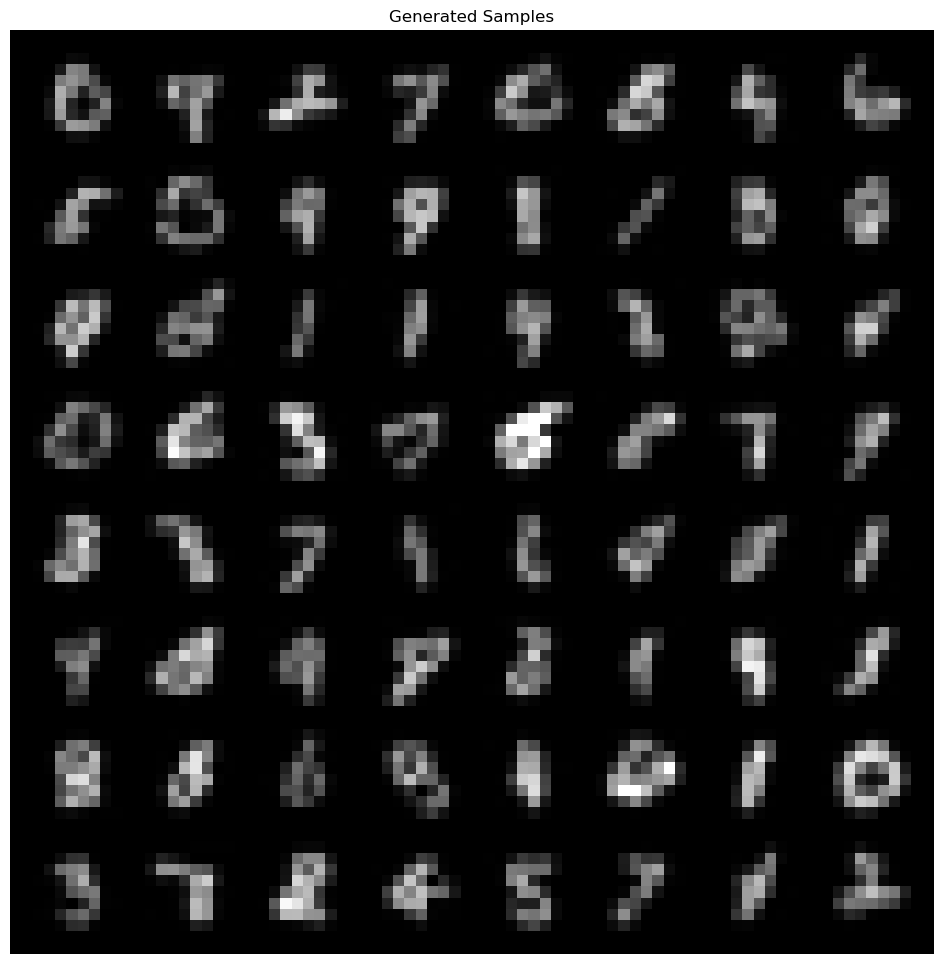

In [39]:
# Visualization of Generated Samples
flow.load_state_dict(torch.load('best_Glow_MNIST.pth'))
flow.eval()

# compute the log likelihood of the test set
total_log_prob = 0
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        log_prob = flow.log_prob(x, y)
        total_log_prob += log_prob.sum().item()

    avg_log_prob = total_log_prob / len(test_loader.dataset)
    print("Average Log Probability: {:.4f}".format(avg_log_prob))

with torch.no_grad():
    samples, _ = flow.sample(64)
    # clamp the samples to [0, 1]
    samples = torch.clamp(samples, 0, 1)
    print("Shape of samples:", samples.shape)


# Reshape and visualize
samples = samples.view(-1, 1, 8, 8).cpu()
grid = torchvision.utils.make_grid(samples, nrow=8, normalize=False)
plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.title('Generated Samples')
plt.axis('off')
plt.show()

In [40]:
import torch
import torchvision
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(8),
    torchvision.transforms.ToTensor(),
    # Add Gaussian noise for dequantization
    # torchvision.transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),
    nf.utils.Scale(255. / 256.), nf.utils.Jitter(1 / 256.),
    torchvision.transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(8),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),
    nf.utils.Scale(255. / 256.), nf.utils.Jitter(1 / 256.),
    torchvision.transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

# Load MNIST datasets
ds_MNIST_train = torchvision.datasets.MNIST(
    root='MNIST',
    train=True,
    download=True,
    transform=transform_train
)

ds_MNIST_test = torchvision.datasets.MNIST(
    root='MNIST',
    train=False,
    download=True,
    transform=transform_test
)

# DataLoader setup
batch_size = 256
train_loader = DataLoader(ds_MNIST_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(ds_MNIST_test, batch_size=batch_size, shuffle=False)

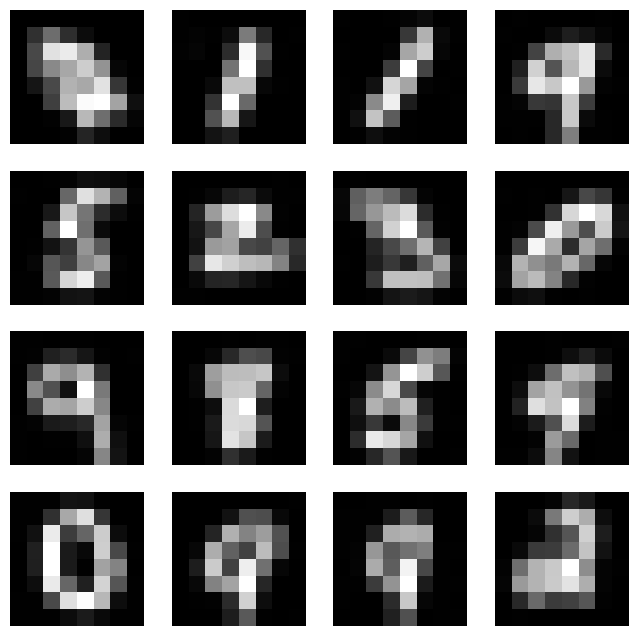

In [41]:
# visualize the data
images, labels = next(iter(train_loader))
plt.figure(figsize=(8, 8))
for i, image in enumerate(images[:16]):
    plt.subplot(4, 4, i+1)
    plt.imshow(image.view(8, 8).numpy(), cmap='gray')
    plt.axis('off')
plt.show()

In [42]:
def build_maf_model(input_dim: int, num_classes: int = None) -> nf.NormalizingFlow:
    """
    Constructs a Masked Autoregressive Flow (MAF) model with permutation layers
    
    Args:
        input_dim: Dimension of input data (flattened image size)
        num_classes: Optional number of classes for conditional modeling
        
    Returns:
        Configured MAF model with alternating autoregressive and permutation layers
    """
    # Architecture configuration
    NUM_LAYERS = 5               # Total number of autoregressive blocks
    HIDDEN_UNITS = 128           # Size of hidden layers in MADE network
    NUM_BLOCKS = 3               # Number of hidden layers per autoregressive block
    
    # Set random seed for reproducibility
    torch.manual_seed(0)

    # Initialize base distribution (standard normal)
    base_dist = nf.distributions.DiagGaussian(shape=(input_dim,))

    # Construct flow layers
    flow_layers = []
    for _ in range(NUM_LAYERS):
        # Autoregressive transformation layer
        ar_layer = nf.flows.affine.MaskedAffineAutoregressive(
            features=input_dim,
            hidden_features=HIDDEN_UNITS,
            num_blocks=NUM_BLOCKS
        )
        flow_layers.append(ar_layer)
        
        # Permutation layer for dimension shuffling
        perm_layer = nf.flows.Permute(num_channels=input_dim)
        flow_layers.append(perm_layer)

    # Instantiate the normalizing flow model
    return nf.NormalizingFlow(q0=base_dist, flows=flow_layers)


INPUT_DIM = 8 * 8  # Flattened 8x8 image
flow = build_maf_model(input_dim=INPUT_DIM)

flow = flow.to(device)

# Verify model structure
print(f"MAF Model Summary:")
print(f"• Number of layers: {len(flow.flows)}")
print(f"• Base distribution: {flow.q0.__class__.__name__}")
print(f"• Device: {next(flow.parameters()).device}")
print(f"• Trainable parameters: {sum(p.numel() for p in flow.parameters()):,}")

MAF Model Summary:
• Number of layers: 10
• Base distribution: DiagGaussian
• Device: cuda:0
• Trainable parameters: 619,648


In [43]:
learning_rate = 1e-3

# optimizer
optimizer = optim.Adam(flow.parameters(), lr=learning_rate, weight_decay=1e-5)

# scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir="runs/MAF_MNIST")

# training loop
best_val_loss = 0
num_epochs = 10
step = 0
for epoch in range(num_epochs):
    flow.train()
    total_train_loss = 0
    for x, _ in train_loader:
        x = x.view(x.size(0), -1)
        x = x.to(device)
        optimizer.zero_grad()
        loss = flow.forward_kld(x)
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print("Epoch: {}, Step: {}, Loss: {:.4f}".format(epoch, step, loss.item()))
        step += 1

        total_train_loss += loss.item() * x.size(0)

    print("Epoch: {}, Loss: {:.4f}".format(epoch, loss.item()))

    avg_train_loss = total_train_loss / len(train_loader.dataset)
    print(f"Epoch: {epoch}, Train Loss: {avg_train_loss:.4f}")

    # Validation phase
    flow.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            loss = flow.forward_kld(x)
            total_val_loss += loss.item() * x.size(0)

    avg_val_loss = total_val_loss / len(test_loader.dataset)

    # Logging
    print(
        f"Epoch: {epoch}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}"
    )
    writer.add_scalar("Loss/Train", avg_train_loss, epoch)
    writer.add_scalar("Loss/Validation", avg_val_loss, epoch)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(flow.state_dict(), "best_MAF_MNIST.pth")
        print("Model checkpoint saved.")

    # Step the scheduler
    scheduler.step()

writer.close()

Epoch: 0, Step: 0, Loss: 28.2458
Epoch: 0, Step: 100, Loss: -56.3170
Epoch: 0, Step: 200, Loss: -96.4476
Epoch: 0, Loss: -81.7240
Epoch: 0, Train Loss: -59.2856
Epoch: 0, Train Loss: -59.2856, Validation Loss: -84.4577
Model checkpoint saved.
Epoch: 1, Step: 300, Loss: -108.6290
Epoch: 1, Step: 400, Loss: -82.9333
Epoch: 1, Loss: -74.5692
Epoch: 1, Train Loss: -88.4860
Epoch: 1, Train Loss: -88.4860, Validation Loss: -74.7991
Epoch: 2, Step: 500, Loss: -100.2916
Epoch: 2, Step: 600, Loss: -100.2621
Epoch: 2, Step: 700, Loss: -118.7567
Epoch: 2, Loss: -123.9408
Epoch: 2, Train Loss: -107.4156
Epoch: 2, Train Loss: -107.4156, Validation Loss: -126.7518
Model checkpoint saved.
Epoch: 3, Step: 800, Loss: -112.2045
Epoch: 3, Step: 900, Loss: -125.4509
Epoch: 3, Loss: -112.2801
Epoch: 3, Train Loss: -119.5523
Epoch: 3, Train Loss: -119.5523, Validation Loss: -99.1869
Epoch: 4, Step: 1000, Loss: -133.1962
Epoch: 4, Step: 1100, Loss: -142.4477
Epoch: 4, Loss: -137.3704
Epoch: 4, Train Loss: -1

Average Log Probability: 152.2933
Shape of samples: torch.Size([64, 64])


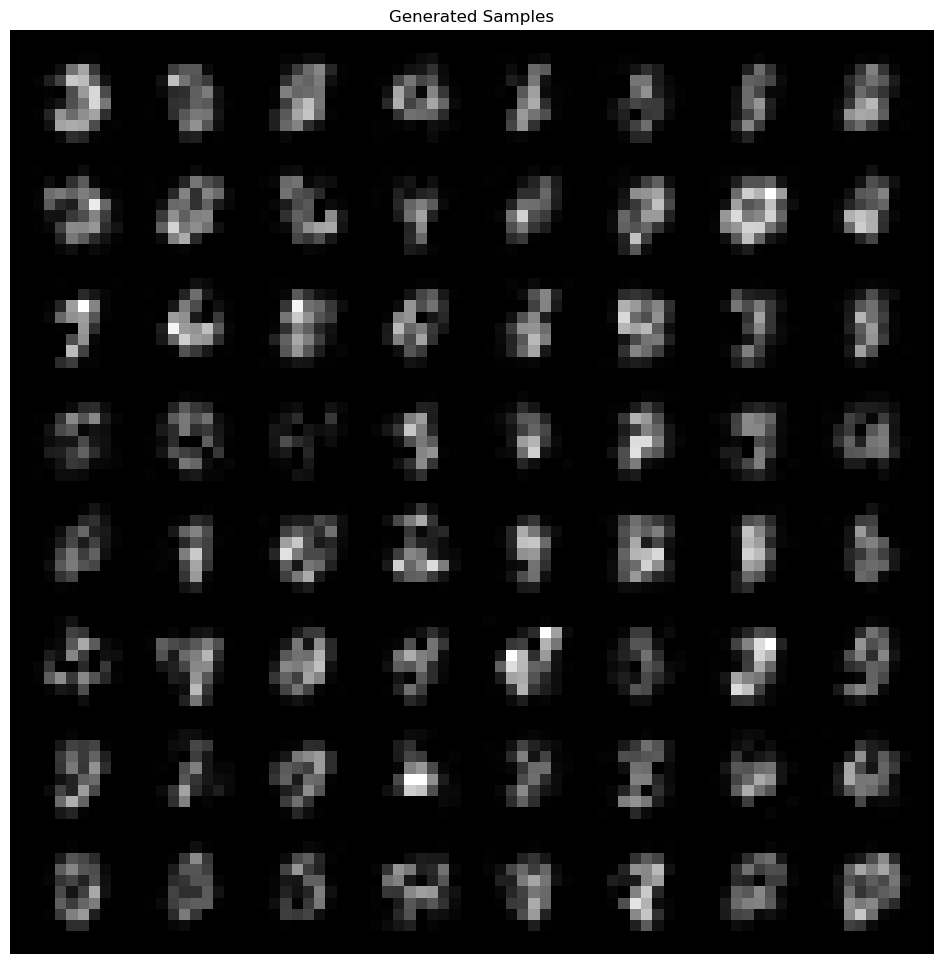

In [45]:
# Visualization of Generated Samples
flow.load_state_dict(torch.load('best_MAF_MNIST.pth'))
flow.eval()

# compute the log likelihood of the test set
total_log_prob = 0
with torch.no_grad():
    for x, _ in test_loader:
        x = x.view(x.size(0), -1)
        x = x.to(device)
        log_prob = flow.log_prob(x)
        total_log_prob += log_prob.sum().item()

    avg_log_prob = total_log_prob / len(test_loader.dataset)
    print("Average Log Probability: {:.4f}".format(avg_log_prob))

with torch.no_grad():
    samples, _ = flow.sample(64)
    # clamp samples to [0, 1]
    samples = torch.clamp(samples, 0, 1)
    print("Shape of samples:", samples.shape)


# Reshape and visualize
samples = samples.view(-1, 1, 8, 8).cpu()
grid = torchvision.utils.make_grid(samples, nrow=8, normalize=False)
plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.title('Generated Samples')
plt.axis('off')
plt.show()

## Question 2: WaveNet for Image Modeling

- Pick a WaveNet-typed model (e.g., WaveNet, ParallelWaveNet).
- Train the model for image modelling on MNIST.
- You can resize the MNIST images to 7 × 7 pixels to reduce computational complexity.

Some reference:
- https://medium.com/@evinpinar/wavenet-implementation-and-experiments-2d2ee57105d5
- https://github.com/kan-bayashi/ParallelWaveGAN?tab=readme-ov-file
- https://github.com/Zeta36/tensorflow-image-wavenet

For this question, I worked with:

- None

For this question, I referenced a few sites/ papers/ github repositories, especially:

- https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial12/Autoregressive_Image_Modeling.html

I spent 7 hours on this question, I have some suggestions:

1. Maybe some hints that WaveNet is for audio modeling, and to adapt it for image modeling, the equivalent will be PixelCNN, since PixelCNN is used for autoregressive image generation through causal convolutions. While WaveNet models temporal dependencies in 1D audio signals using dilated causal convolutions, PixelCNN extends this concept to 2D spatial relationships by using masked convolutions that prevent information flow from future pixels (to the right/below). Both architectures maintain the autoregressive property where each output element (pixel/audio sample) depends only on previous elements through a prescribed generation order (raster scan for images, time sequence for audio).

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

# Pytorch lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install pytorch-lightning
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to folder for MNIST dataset
DATASET_PATH = "./MNIST/"
# Path to folder for storing the trained models in this question
CHECKPOINT_PATH = "./checkpoints/PixelCNN/"

# Set seed
pl.seed_everything(42)

# Reproducibility for GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Reproducibility for MPS
torch.backends.mps.deterministic = True
torch.backends.mps.benchmark = False

# Get device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Seed set to 42


Using device: cuda


In [2]:
from utils import _discretize
# # transformations for images, similar to the previous question, except we need to discretize the pixel values
# def _discretize(x):
#     """
#     Discretize the pixel values to 0-255.
#     Need a function to be called, for pickling to work when using num_workers in pytorch lightning dataloader.
#     """
#     return (x * 255).to(torch.long)

transform = transforms.Compose([
    transforms.Resize(11),
    transforms.ToTensor(),
    # not using dequantization since we are going to learn the distribution over the each 256 values for each pixel
    transforms.Lambda(_discretize)
])

# MNIST dataset
train_dataset = datasets.MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# dataloader
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

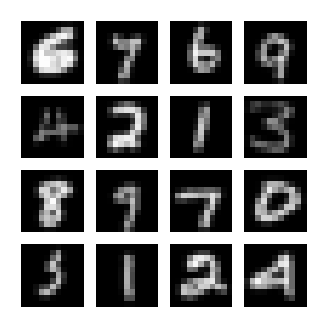

In [3]:
# visualize images
def visualize_images(images, max_rows=4, max_cols=4):
    num_imgs = images.shape[0] if isinstance(images, torch.Tensor) else len(images)
    nrow = min(num_imgs, max_rows)
    ncol = min(num_imgs, max_cols)
    imgs = torchvision.utils.make_grid(images, nrow=ncol, pad_value=255)
    imgs = imgs.clamp(0, 255)
    plt.figure(figsize=(ncol, nrow))
    plt.imshow(imgs.cpu().permute(1, 2, 0))
    plt.axis('off')
    plt.show()

# visualize training images
train_images = [train_set[i][0] for i in range(16)]
visualize_images(train_images)

In [4]:
# implement masked convolution module
class MaskedConv2d(nn.Module):
    """
    Implements a convolution with mask applied to the weights.
    The mask ensures that the output can only depend on the pixels that are to the right and below the current pixel.
    This is achieved by having a random mask with all values set to 1 except for the pixels that are to the right and below the current pixel.

    Inputs:
        in_channels: int, number of input channels
        out_channels: int, number of output channels
        mask: torch.Tensor, mask with shape (kernel_size_h, kernel_size_w) with 0s where the convolution is masked
        kwargs: other arguments for the convolution
    """
    def __init__(self, in_channels, out_channels, mask, **kwargs):
        super(MaskedConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # calculate padding automatically
        kernel_size = (mask.shape[0], mask.shape[1])
        dilation = 1 if 'dilation' not in kwargs else kwargs['dilation']
        padding = tuple([dilation*(kernel_size[i]-1)//2 for i in range(2)])
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, **kwargs)

        # buffer for mask
        # to allow the mask to be saved and loaded with the model
        # also allows the mask to be moved to the correct device
        # without buffer, need to handle device movement manually
        # also registering it as a buffer means it is not a parameter and not subject to gradient descent
        # note we don't want it to update during training
        self.register_buffer('mask', mask[None, None])

    def forward(self, x):
        # apply mask to the weights
        self.conv.weight.data *= self.mask
        return self.conv(x)

In [5]:
# implement vertical and horizontal convolution stacks
# Although we can stack few masked convolutions on top of each other (like in PixelCNN),
# the issue is we will miss out on pixels on the upper right (blind spot), the authors of
# PixelCNN proposed a fix by splitting the convolutions into a vertical and horizontal stack.
# The vertical stack looks at the pixels above the current pixel, while the horizontal stack looks at the pixels to the left of the current pixel.
# This way, we can ensure that all pixels are considered.
class VerticalStackConvolution(MaskedConv2d):
    """
    Implements a vertical stack of masked convolutions.
    Masks out pixels below. To reduce computational complexity,
    we can reduce the kernel size in height. But for simplicity,
    we use the same kernel size for both height and width and employ masking instead.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, mask_center=False, **kwargs):

        # create mask
        mask = torch.ones(kernel_size, kernel_size)
        mask[kernel_size // 2 + 1:, :] = 0

        # Mask the center row for the first convolution
        if mask_center:
            mask[kernel_size // 2, :] = 0


        super().__init__(in_channels, out_channels, mask, **kwargs)

class HorizontalStackConvolution(MaskedConv2d):
    """
    Implements a horizontal stack of masked convolutions.
    Masks out pixels on the left.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, mask_center=False, **kwargs):

        # only have a size of 1 in height, since we only look at the pixels on the left
        mask = torch.ones(1, kernel_size)
        mask[:, kernel_size // 2 + 1:] = 0

        # Mask the center column for the first convolution
        if mask_center:
            mask[:, kernel_size // 2] = 0


        super().__init__(in_channels, out_channels, mask, **kwargs)

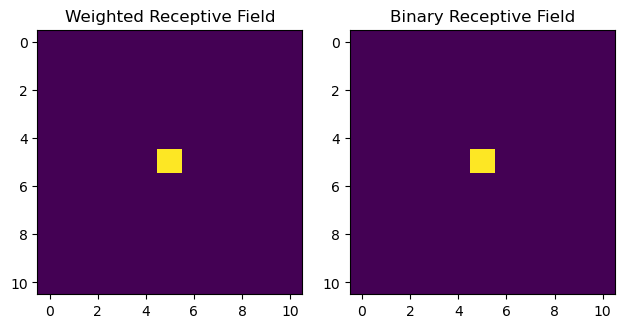

In [6]:
# validate the masked convolutions by visualizing the receptive fields

inp_img = torch.zeros(1, 1, 11, 11)
inp_img.requires_grad_()

def show_center_receptive_field(img, out):
    """
    Calculates gradients of input image with respect to output center pixel,
    and visualizes the overall receptive field.

    Inputs:
        img: torch.Tensor, input image with shape (1, 1, H, W)
        out: torch.Tensor, output features or loss which is used for backprop,
            should be the output of the network/computation graph
    """
    
    # Create clone of output that requires grad
    out = out.clone().requires_grad_(True)
    
    # calculate gradients
    loss = out[0, :, img.shape[2] // 2, img.shape[3] // 2].sum()
    loss.backward(retain_graph=True)
    
    # Get gradients from original input
    img_grads = img.grad.abs()
    img.grad.data.zero_()
    
    # # calculate gradients
    # loss = out[0, :, img.shape[2] // 2, img.shape[3] // 2].sum() # L1 loss
    # loss.backward(retain_graph=True) # Retain graph since we want to stack multiple layers and show the receptive field of all of them.
    # img_grads = img.grad.abs()
    # img.grad.fill_(0) # Clear the gradient

    # Plot the receptive field
    img = img_grads.squeeze().cpu().numpy()
    fig, ax = plt.subplots(1, 2)
    pos = ax[0].imshow(img)
    ax[1].imshow(img > 0)

    # mark the center of the receptive field if it does not have gradients
    show_center = (img[img.shape[0] // 2, img.shape[1] // 2] == 0)
    if show_center:
        center_pix = np.zeros(img.shape + (4,))
        center_pix[img.shape[0] // 2, img.shape[1] // 2, :] = [1, 0, 0, 1]
        ax[0].imshow(center_pix)
        ax[1].imshow(center_pix)

    ax[0].set_title('Weighted Receptive Field')
    ax[1].set_title('Binary Receptive Field')
    plt.tight_layout()
    plt.show()

show_center_receptive_field(inp_img, inp_img)

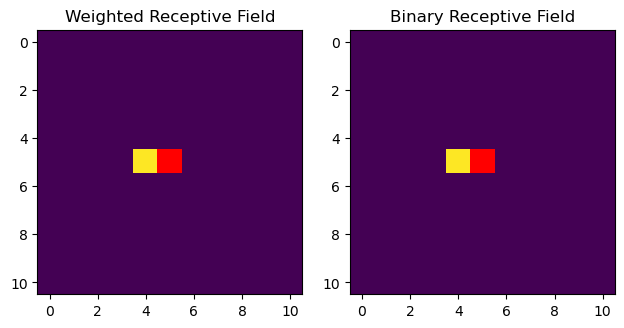

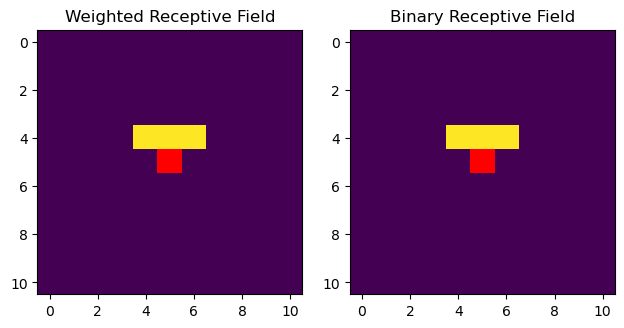

In [7]:
# visualize horizontal and vertical convolutions

# horizontal convolution
horizontal_conv = HorizontalStackConvolution(in_channels=1, out_channels=1, kernel_size=3, mask_center=True)
horizontal_conv.conv.weight.data.fill_(1)
horizontal_conv.conv.bias.data.fill_(0)
show_center_receptive_field(inp_img, horizontal_conv(inp_img))

# vertical convolution
vertical_conv = VerticalStackConvolution(in_channels=1, out_channels=1, kernel_size=3, mask_center=True)
vertical_conv.conv.weight.data.fill_(1)
vertical_conv.conv.bias.data.fill_(0)
show_center_receptive_field(inp_img, vertical_conv(inp_img))

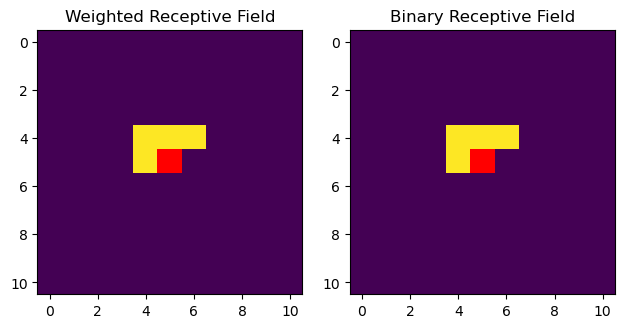

In [8]:
# combine horizontal and vertical convolutions
show_center_receptive_field(inp_img, horizontal_conv(inp_img) + vertical_conv(inp_img))

Layer 1 Receptive Field:


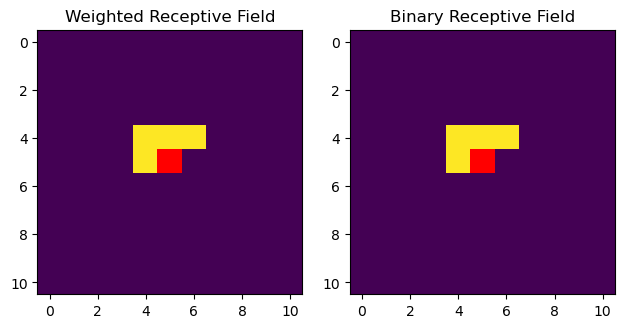

Layer 2 Receptive Field:


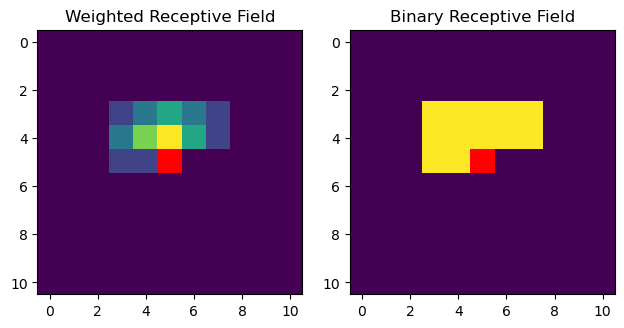

Layer 3 Receptive Field:


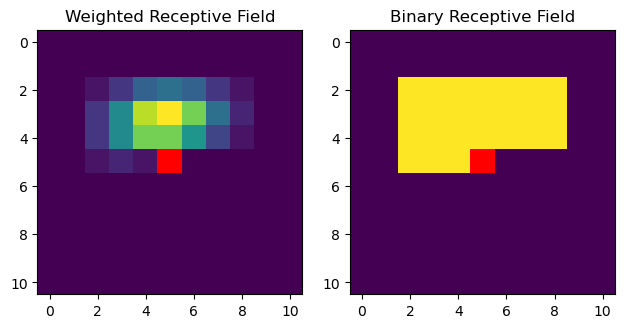

Layer 4 Receptive Field:


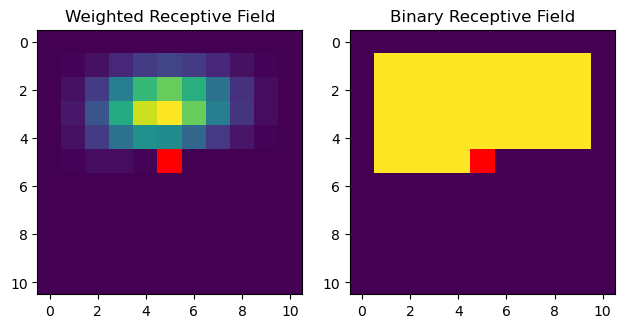

Layer 5 Receptive Field:


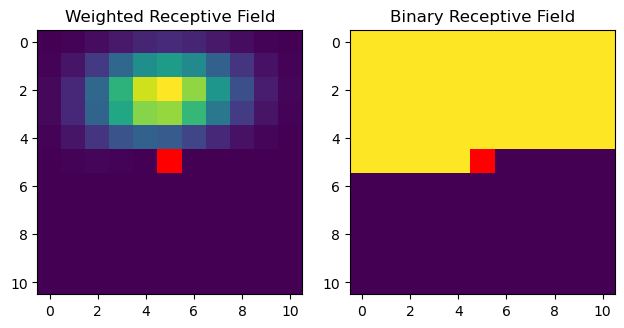

In [9]:
# to stack multiple layers:
# horizontal convolutions can operate on the joint features of previous horizontal and vertical convolutions
#! vertical convolutions can only operate on the features of previous vertical convolutions
#! Subsequent convolutions should not be masking the center pixel, since it is already independent of its actual value

# test it on 4 layers. Reuse the convolutions for simplicity. In practice, we can use different convolutions for each layer.
# initialize the convolutions with equal weight to all input pixels, the first layer should have a mask center pixel
horizontal_conv = HorizontalStackConvolution(in_channels=1, out_channels=1, kernel_size=3, mask_center=True)
vertical_conv = VerticalStackConvolution(in_channels=1, out_channels=1, kernel_size=3, mask_center=True)
horizontal_conv.conv.weight.data.fill_(1)
vertical_conv.conv.weight.data.fill_(1)
horizontal_conv.conv.bias.data.fill_(0)
vertical_conv.conv.bias.data.fill_(0)

inp_img = torch.zeros(1, 1, 11, 11)
inp_img.requires_grad = True

vert_out = vertical_conv(inp_img)
horiz_out = horizontal_conv(inp_img)
horiz_out = horiz_out + vert_out
print("Layer 1 Receptive Field:")
show_center_receptive_field(inp_img, horiz_out)

# now the convolutions should not mask the center pixel
horizontal_conv = HorizontalStackConvolution(in_channels=1, out_channels=1, kernel_size=3, mask_center=False)
vertical_conv = VerticalStackConvolution(in_channels=1, out_channels=1, kernel_size=3, mask_center=False)
horizontal_conv.conv.weight.data.fill_(1)
vertical_conv.conv.weight.data.fill_(1)
horizontal_conv.conv.bias.data.fill_(0)
vertical_conv.conv.bias.data.fill_(0)

# stack the convolutions
for layer in range(4):
    vert_out = vertical_conv(vert_out)
    horiz_out = horizontal_conv(horiz_out) + vert_out
    print(f"Layer {layer + 2} Receptive Field:")
    show_center_receptive_field(inp_img, horiz_out)



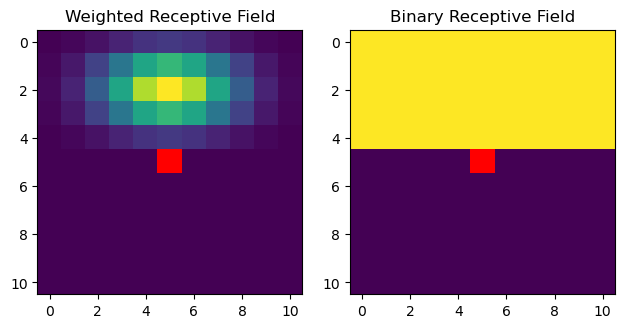

In [10]:
# check receptive field for the vertical stack after 4 layers
show_center_receptive_field(inp_img, vert_out)

del horizontal_conv, vertical_conv, horiz_out, vert_out, inp_img

In [11]:
# gated masked convolutions
class GatedMaskedConv2d(nn.Module):
    """
    Implements a gated masked convolution.
    """
    def __init__(self, in_channels, **kwargs):
        super().__init__()

        self.conv_vert = VerticalStackConvolution(in_channels=in_channels, out_channels=2*in_channels, **kwargs)
        self.conv_horiz = HorizontalStackConvolution(in_channels=in_channels, out_channels=2*in_channels, **kwargs)
        self.conv_vert_to_horiz = nn.Conv2d(2*in_channels, 2*in_channels, kernel_size=1, padding=0)
        self.conv_horiz_1x1 = nn.Conv2d(in_channels, in_channels, kernel_size=1, padding=0)


    def forward(self, vert_stack, horiz_stack):
        # Vertical stack
        vert_stack_feat = self.conv_vert(vert_stack)
        vert_val, vert_gate = vert_stack_feat.chunk(2, dim=1)
        vert_stack_out = torch.tanh(vert_val) * torch.sigmoid(vert_gate)

        # Horizontal stack
        horiz_stack_feat = self.conv_horiz(horiz_stack)
        horiz_stack_feat = horiz_stack_feat + self.conv_vert_to_horiz(vert_stack_feat)
        horiz_val, horiz_gate = horiz_stack_feat.chunk(2, dim=1)
        horiz_stack_feat = torch.tanh(horiz_val) * torch.sigmoid(horiz_gate)
        horiz_stack_out = self.conv_horiz_1x1(horiz_stack_feat)
        horiz_stack_out = horiz_stack_out + horiz_stack

        return vert_stack_out, horiz_stack_out

In [12]:
class PixelCNN(pl.LightningModule):

    def __init__(self, in_channels, hidden_channels, num_layers):
        """
        Constructs a PixelCNN model for autoregressive image modeling.

        Architecture:
        - Two initial masked convolutions (VerticalStackConvolution and HorizontalStackConvolution)
          are applied to the input image to create separate vertical and horizontal stacks.
        - The network includes a series of gated masked convolution layers (GatedMaskedConv2d)
          that use dilation to increase the receptive field, capturing context from previous pixels.
        - A final 1x1 convolution (self.conv_out) outputs logits for each of the 256 discrete
          pixel values for every image channel, height, and width position.

        Args:
            in_channels (int): Number of input channels in the image (e.g., 1 for grayscale).
            hidden_channels (int): Number of channels in hidden layers.
            num_layers (int): Number of layers in the model (not directly used here as conv_block length is fixed).
        """
        super(PixelCNN, self).__init__()
        self.save_hyperparameters()

        # initial convolutions, skip the center pixel
        self.conv_init_vert = VerticalStackConvolution(
            in_channels=in_channels, 
            out_channels=hidden_channels, 
            kernel_size=3, 
            mask_center=True
        )
        self.conv_init_horiz = HorizontalStackConvolution(
            in_channels=in_channels, 
            out_channels=hidden_channels, 
            kernel_size=3, 
            mask_center=True
        )

        # convolution block of PixelCNN, we use dilation to increase receptive field.
        # The alternating gated masked convolutions capture dependencies among pixels.
        self.conv_block = nn.ModuleList([
            GatedMaskedConv2d(hidden_channels),
            GatedMaskedConv2d(hidden_channels, dilation=1),
            GatedMaskedConv2d(hidden_channels),
            GatedMaskedConv2d(hidden_channels, dilation=2),
            GatedMaskedConv2d(hidden_channels),
            GatedMaskedConv2d(hidden_channels, dilation=1),
            GatedMaskedConv2d(hidden_channels),
        ])

        # output convolution: applies a 1x1 kernel to yield logits for the 256 discrete levels
        # for each pixel (e.g. pixel intensity values in the range [0, 255]).
        self.conv_out = nn.Conv2d(hidden_channels, in_channels * 256, kernel_size=1, padding=0)

    def forward(self, x):
        """
        Logic behind the forward pass:
        1. Scale the input image tensor from [0, 255] to [-1, 1]. The scaling is done by:
              x_scaled = (x.float() / 255.) * 2 - 1
        2. Pass the input through the initial vertical and horizontal masked convolutions.
           These layers enforce the autoregressive property by ensuring the current pixel does
           not depend on future pixels.
        3. Sequentially apply the gated masked convolution blocks to model the conditional 
           dependencies across pixels.
        4. Apply an ELU activation to the horizontal stack's output (non-linearity on residual connection).
        5. Pass through a 1x1 convolution (self.conv_out) to produce output logits.
        6. Reshape the output to have shape [B, 256, C_out, H, W], where 256 is the number of discrete 
           classes (pixel values). This represents the unnormalized log-probabilities for each pixel value.

    
        Given an image x, the model approximates the distribution:
            p(x) = ∏_{i} p(x_i | x_{< i})
        where each pixel's conditional probability is given by the softmax over the logits:
            p(x_{b,c,h,w}=v) = exp(l_{b,v,c,h,w}) / ∑_{v'=0}^{255} exp(l_{b,v',c,h,w])

        Args:
            x (torch.Tensor): Input tensor of shape [B, C, H, W] with pixel values in [0, 255].

        Returns:
            torch.Tensor: Logits reshaped to [B, 256, (in_channels*256)/256, H, W], effectively [B, 256, C, H, W].
        """
        # Scale input from 0-255 to [-1, 1]
        x = x.float() / 255. * 2 - 1

        # Initial masked convolutions for autoregressive conditioning
        vert_stack = self.conv_init_vert(x)
        horiz_stack = self.conv_init_horiz(x)

        # Apply gated masked convolution blocks
        for conv in self.conv_block:
            vert_stack, horiz_stack = conv(vert_stack, horiz_stack)

        # Apply ELU activation for non-linearity before the final convolution
        out = self.conv_out(F.elu(horiz_stack))

        # Reshape output to have logits for 256 classes per pixel.
        return out.reshape(out.shape[0], 256, out.shape[1] // 256, out.shape[2], out.shape[3])

    def compute_likelihood(self, x):
        """
        Computes the negative log-likelihood (NLL) and converts it to bits per dimension (BPD).

        Likelihood explanation:
        - The network outputs logits for a categorical distribution over 256 possible pixel values.
        - For a given image, the likelihood is defined as:
              p(x) = ∏_{b,c,h,w} p(x_{b,c,h,w})
          where:
              p(x_{b,c,h,w} = v) = softmax(logits) evaluated at v.
        - The negative log-likelihood (NLL) for each pixel is:
              NLL_{b,c,h,w} = -log p(x_{b,c,h,w})
        - The average NLL over image dimensions and batch is computed and then divided by
          log2(e) to convert from nats (natural logarithm) to bits.

        For an image x, the bits per dimension (BPD) is computed as:
            BPD = (1/(# pixels)) * NLL(x) / log2(e)
        where log2(e) ≈ 1.4427.
        BPD is a measure of the average number of bits required to represent each pixel in the image.
        Used in the PixelCNN paper to evaluate the performance of the model.

        Args:
            x (torch.Tensor): Input tensor of shape [B, C, H, W] with pixel values in [0, 255].

        Returns:
            torch.Tensor: Average bits-per-dimension (BPD) across the batch.
        """
        out = self.forward(x)
        # Compute cross-entropy loss per pixel. Note that F.cross_entropy expects logits and target,
        # where target is assumed to be in the range [0, 255] (integer class labels).
        nll = F.cross_entropy(out, x, reduction='none')
        # Average over channel, height, and width dimensions for each sample and convert from nats to bits.
        bpd = nll.mean(dim=(1, 2, 3)) / np.log2(np.exp(1))
        return bpd.mean()

    @torch.no_grad()
    def sample(self, img_shape, img=None):
        """
        Generates samples from the PixelCNN model using autoregressive sampling.

        Sampling Process:
        - The model follows the autoregressive factorization: 
              p(x) = ∏_{i} p(x_i | x_{< i})
          where pixels are generated sequentially.
        - The input argument 'img' is a partially filled image tensor. Unfilled pixels are represented by -1.
          If 'img' is None, an initial tensor filled with -1 is created.
        - The sampling proceeds in a raster scan order over the image dimensions (height, width) and channels.
        - For each pixel location (at coordinates h, w, and channel c):
            1. Check if the pixel has already been sampled (i.e., its value is not -1). If so, skip.
            2. Compute the model's logits by performing a forward pass on the partially completed image.
               Note that only rows up to h+1 are provided to ensure proper conditioning.
            3. Extract the logits corresponding to the current pixel.
            4. Apply a softmax function to the logits to obtain a probability distribution over the 256 possible pixel values.
            5. Sample a pixel value from this categorical distribution using torch.multinomial.
            6. Assign the sampled value to the current pixel position.
        - This process continues until all pixel positions are filled.

        The math behind sampling the value of one pixel:
            For pixel (b, c, h, w), let l = logits corresponding to that pixel.
            The probability of pixel value v is:
              p(v) = exp(l_v) / ∑_{v=0}^{255} exp(l_v)
            A value is then sampled from this distribution.

        Args:
            img_shape (tuple): Desired shape of the output image tensor [B, C, H, W].
            img (torch.Tensor, optional): Partially filled image tensor. Unfilled pixels should be marked with -1.
                                          Default is None, which initializes all pixels to -1.

        Returns:
            torch.Tensor: Generated image tensor with sampled pixel values. The tensor shape is [B, C, H, W].
        """
        if img is None:
            img = torch.ones(img_shape) * -1  # Initialize with -1 indicating unsampled pixels

        # Autoregressive generation in raster scan order
        for h in range(img.shape[2]):
            for w in range(img.shape[3]):
                for c in range(img.shape[1]):
                    # If this pixel is already sampled, skip it.
                    if (img[:, c, h, w] != -1).all().item():
                        continue

                    # Forward pass using the current partially-generated image.
                    # Only rows up to h+1 are considered to maintain autoregressive conditioning.
                    pred = self.forward(img[:, :, :h+1, :])
                    # Compute probability distribution over 256 pixel values via softmax.
                    probs = F.softmax(pred[:, :, c, h, w], dim=-1)
                    # Sample a pixel value from the categorical distribution.
                    img[:, c, h, w] = torch.multinomial(probs, num_samples=1).squeeze(-1)
        return img

    def configure_optimizers(self):
        """
        Configures the optimizer and learning rate scheduler for training.

        Returns:
            tuple: ([optimizer], [scheduler])
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        """
        Training step to compute the loss for a batch.

        Args:
            batch (tuple): A tuple containing the image tensor and its corresponding labels.
                           For PixelCNN, only the images (batch[0]) are used.
            batch_idx (int): Index of the batch.

        Returns:
            torch.Tensor: Computed loss (negative log-likelihood in bits per dimension).
        """
        loss = self.compute_likelihood(batch[0])
        self.log('train_bpd', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation step to compute and log the loss for a batch.

        Args:
            batch (tuple): A tuple containing the image tensor and its corresponding labels.
                           For PixelCNN, only the images (batch[0]) are used.
            batch_idx (int): Index of the batch.
        """
        loss = self.compute_likelihood(batch[0])
        self.log('val_bpd', loss)

    def test_step(self, batch, batch_idx):
        """
        Test step to compute and log the loss for a batch.

        Args:
            batch (tuple): A tuple containing the image tensor and its corresponding labels.
                           For PixelCNN, only the images (batch[0]) are used.
            batch_idx (int): Index of the batch.
        """
        loss = self.compute_likelihood(batch[0])
        self.log('test_bpd', loss)

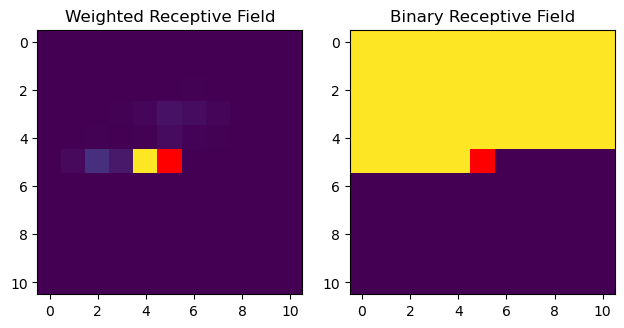

In [13]:
test_model = PixelCNN(in_channels=1, hidden_channels=64, num_layers=4)
inp = torch.zeros(1,1,11,11)
inp.requires_grad_()
out = test_model(inp)
show_center_receptive_field(inp, out.squeeze(dim=2))
del inp, out, test_model

In [14]:
import os
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger


# Create generation callback to monitor training progress
class GenerateCallback(pl.Callback):
    def __init__(self, every_n_epochs=1):
        """
        Inputs:
            every_n_epochs - Only save those images every N epochs (default: 1)
        """
        super().__init__()
        self.every_n_epochs = every_n_epochs

    def on_epoch_end(self, trainer, pl_module):
        """
        This function is called after every epoch.
        """
        if (trainer.current_epoch+1) % self.every_n_epochs == 0:
            # Generate images
            with torch.no_grad():
                pl_module.eval()
                imgs_shape = (4, 1, 11, 11)  # Generate 4 images
                imgs = pl_module.sample(imgs_shape)
                pl_module.train()

            # Plot and save images
            imgs = imgs.cpu()
            imgs_grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1))
            trainer.logger.experiment.add_image("generated_images", imgs_grid, global_step=trainer.global_step)

# # Set up model and training
# CHECKPOINT_PATH = "saved_models/pixelcnn.ckpt"
# os.makedirs(os.path.dirname(CHECKPOINT_PATH), exist_ok=True)

def train_pixelcnn(train_loader, val_loader, **kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(
        # default_root_dir=os.path.dirname(CHECKPOINT_PATH),
        accelerator="auto",
        devices=1,
        max_epochs=kwargs.get("max_epochs", 100),
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_bpd"),
            GenerateCallback(every_n_epochs=5),
            # Early stopping
            EarlyStopping(monitor="val_bpd", mode="min", patience=5, verbose=True),
            LearningRateMonitor(logging_interval='epoch')
        ],
        enable_progress_bar=True,
        logger=TensorBoardLogger("lightning_logs", name="pixelcnn")
    )

    # Check if pretrained model exists, if yes load it
    if os.path.isfile(CHECKPOINT_PATH):
        print("Found pretrained model, loading...")
        model = PixelCNN.load_from_checkpoint(CHECKPOINT_PATH)
    else:
        print("Training model from scratch...")
        model = PixelCNN(in_channels=1, hidden_channels=64, num_layers=7)
        trainer.fit(model, train_loader, val_loader)
        # Load best model after training
        model = PixelCNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation and test set
    val_result = trainer.validate(model, val_loader, verbose=True)
    test_result = trainer.test(model, test_loader, verbose=True)

    return model, val_result, test_result

if __name__ == "__main__":

    transform = transforms.Compose([
        transforms.Resize(11),
        transforms.ToTensor(),
        # not using dequantization since we are going to learn the distribution over the each 256 values for each pixel
        # transforms.Lambda(lambda x: x + 0.01 * torch.rand_like(x) / 256.),
        # normalize to mean 0 and std 1 using standard MNIST mean and std
        # transforms.Normalize((0.1307,), (0.3081,))

        # need to discretize instead
        # DiscretizeTransform()
        transforms.Lambda(_discretize)
    ])

    train_set = torchvision.datasets.MNIST(root='./MNIST', train=True, transform=transform, download=True)
    val_set = torchvision.datasets.MNIST(root='./MNIST', train=False, transform=transform, download=True)
    test_dataset = torchvision.datasets.MNIST(root='./MNIST', train=False, transform=transform, download=True)

    train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_set, batch_size=256, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)

    # Train model with default parameters
    model, val_result, test_result = train_pixelcnn(train_loader, val_loader, max_epochs=10)

    print(f"Validation BPD: {val_result[0]['val_bpd']:.4f}")
    print(f"Test BPD: {test_result[0]['test_bpd']:.4f}")

/hpc/dctrl/jy384/miniconda3/envs/myenv/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/dctrl/jy384/miniconda3/envs/myenv/lib/python3.1 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA RTX 5000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Training model from scratch...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | conv_init_vert  | VerticalStackConvolution   | 640    | train
1 | conv_init_horiz | HorizontalStackConvolution | 256    | train
2 | conv_block      | ModuleList                 | 834 K  | train
3 | conv_out        | Conv2d                     | 16.6 K | train
-----------------------------------------------------------------------
852 K     Trainable params
0         Non-trainable params
852 K     Total params
3.409     Total estimated model params size (MB)
55        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 235/235 [01:47<00:00,  2.18it/s, v_num=2]        

Metric val_bpd improved. New best score: 1.394


Epoch 1: 100%|██████████| 235/235 [01:41<00:00,  2.32it/s, v_num=2]

Metric val_bpd improved by 0.117 >= min_delta = 0.0. New best score: 1.277


Epoch 2: 100%|██████████| 235/235 [01:37<00:00,  2.41it/s, v_num=2]

Metric val_bpd improved by 0.042 >= min_delta = 0.0. New best score: 1.235


Epoch 3: 100%|██████████| 235/235 [01:42<00:00,  2.29it/s, v_num=2]

Metric val_bpd improved by 0.035 >= min_delta = 0.0. New best score: 1.200


Epoch 4: 100%|██████████| 235/235 [01:43<00:00,  2.27it/s, v_num=2]

Metric val_bpd improved by 0.012 >= min_delta = 0.0. New best score: 1.188


Epoch 5: 100%|██████████| 235/235 [01:45<00:00,  2.24it/s, v_num=2]

Metric val_bpd improved by 0.022 >= min_delta = 0.0. New best score: 1.166


Epoch 6: 100%|██████████| 235/235 [01:36<00:00,  2.43it/s, v_num=2]

Metric val_bpd improved by 0.009 >= min_delta = 0.0. New best score: 1.157


Epoch 7: 100%|██████████| 235/235 [01:37<00:00,  2.40it/s, v_num=2]

Metric val_bpd improved by 0.006 >= min_delta = 0.0. New best score: 1.150


Epoch 8: 100%|██████████| 235/235 [01:38<00:00,  2.39it/s, v_num=2]

Metric val_bpd improved by 0.016 >= min_delta = 0.0. New best score: 1.134


Epoch 9: 100%|██████████| 235/235 [01:41<00:00,  2.31it/s, v_num=2]

Metric val_bpd improved by 0.007 >= min_delta = 0.0. New best score: 1.127
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 235/235 [01:41<00:00,  2.31it/s, v_num=2]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 40/40 [00:12<00:00,  3.14it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_bpd          │    1.1270314455032349     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:12<00:00,  3.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_bpd          │    1.1270314455032349     │
└───────────────────────────┴───────────────────────────┘

Validation BPD: 1.1270
Test BPD: 1.1270


Loading checkpoint from: lightning_logs/pixelcnn/version_2/checkpoints/epoch=9-step=2350.ckpt
Runtime Error: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

Trying alternative approach...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


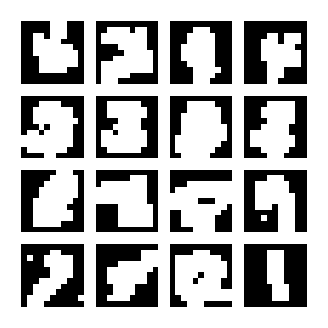

In [16]:
import glob

def load_latest_model():
    # Find all checkpoint files in the Lightning logs directory
    checkpoint_files = glob.glob("lightning_logs/pixelcnn/version_*/checkpoints/*.ckpt")

    if not checkpoint_files:
        raise FileNotFoundError("No checkpoint files found")

    # Get the most recent checkpoint file based on modification time
    latest_checkpoint = max(checkpoint_files, key=os.path.getmtime)
    print(f"Loading checkpoint from: {latest_checkpoint}")

    # Load the model
    model = PixelCNN.load_from_checkpoint(latest_checkpoint)

    # Move model to appropriate device
    device = torch.device("cuda" if torch.cuda.is_available()
                         else "mps" if torch.backends.mps.is_available()
                         else "cpu")
    model = model.to(device)
    model.eval()  # Set to evaluation mode
    return model, device

# Usage
try:
    model, device = load_latest_model()

    # Generate samples
    with torch.no_grad():
        # Create sample tensor on the same device as model
        img_shape = (16, 1, 11, 11)
        samples = model.sample(img_shape=img_shape)

        # Move samples to CPU for visualization
        samples = samples.cpu()

    # Display samples
    samples_grid = torchvision.utils.make_grid(images, nrow=4, pad_value=255)
    samples_grid = samples_grid.clamp(0, 255)
    plt.figure(figsize=(8,8))
    plt.imshow(samples_grid.permute(1,2,0))
    plt.axis('off')
    plt.show()

except FileNotFoundError as e:
    print(f"Error: {e}")
except RuntimeError as e:
    print(f"Runtime Error: {e}")
    print("\nTrying alternative approach...")

    # If the above fails, try forcing CPU execution
    model = model.cpu()
    with torch.no_grad():
        samples = model.sample(img_shape=(16, 1, 11, 11))
        samples = samples.cpu()

    visualize_images(samples)

## Question 3: Energy-based Models

- make a simple energy-based model with E(x,\theta) = f_{\theta}(x). Here, f_{\theta}() is a simple 2-layer convolutional network (CNN). You should design this CNN yourself, which include (at least) 2 convolutional layers.
- train and use Gibbs sampling and Langevin Dynamics method on USPS.

For this question, I worked with:

- Daniel Coble

For this question, I referenced a few sites/ papers/ github repositories, especially:

- https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial8/Deep_Energy_Models.html

I spent 15 hours on this question. I have some suggestions:
1. The gibbs sampling is slow to mix and has very low computational efficiency. Maybe guidelines on what we should expect for the gibbs sampling outcome can help.
2. Also for gibbs sampling, maybe hints on how to improve the sampling outcome can be helpful, since it is very sensitive to the initial conditions and bad initialization can lead to bad sampling outcome.

If you are interested in the above, start thinking about presentation topics and talk to Vahid. <br>
If you are interested in something later on in the class, skim through the slides, also start thinking about presentation topics and talk to Vahid.

In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install pytorch-lightning
    import pytorch_lightning as pl

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

import matplotlib.pyplot as plt

method = 'gibbs'
CHECKPOINT_PATH = f"saved_models/energy_model_{method}.ckpt"
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")



# =============================================================================
# 1. CNN Model for Energy-based Modeling
# =============================================================================

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# class CNNModel(nn.Module):
#     """
#     A convolutional neural network for modeling an energy function.

#     Mathematical Formulation:
#       Given an image x and learnable parameters θ, we define the energy function as
#         E(x; θ) = f_θ(x)
#       where a lower energy is associated with a higher probability.
    
#     Architecture:
#       - A series of convolutional layers with non-linear (Swish) activations.
#       - Final fully-connected layers map the extracted features to a scalar value.
      
#       The network processes the image through a succession of layers. The use of strided
#       convolutions reduces the spatial dimensions, and the nonlinear activations help to capture
#       the complex energy landscape.
#     """
#     def __init__(self, hidden_features=32, out_dim=1, **kwargs):
#         super().__init__()
#         # Define intermediate channel sizes.
#         c_hid1 = hidden_features // 2   # First hidden channel count.
#         c_hid2 = hidden_features        # Intermediate features.
#         c_hid3 = hidden_features * 2    # Expanded feature dimension.

#         # The CNN architecture: progressively reducing spatial resolution while increasing feature complexity.
#         self.cnn_layers = nn.Sequential(
#             nn.Conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4),
#             Swish(),
#             nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1),
#             Swish(),
#             nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1),
#             Swish(),
#             nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1),
#             Swish(),
#             nn.Flatten(),
#             nn.Linear(c_hid3 * 4, c_hid3),
#             Swish(),
#             nn.Linear(c_hid3, out_dim)  # Output energy scalar.
#         )
    
#     def forward(self, x):
#         """
#         Forward pass: computes the energy E(x; θ) for each input.
        
#         Args:
#             x (torch.Tensor): Input images of shape [B, 1, H, W].
        
#         Returns:
#             torch.Tensor: Energy values of shape [B].
#         """
#         # Squeeze reduces any last-singleton dimensions.
#         return self.cnn_layers(x).squeeze(dim=-1)


class CNNModel(nn.Module):
    """
    A convolutional neural network for modeling an energy function.

    Mathematical Formulation:
      E(x; θ) = f_θ(x)
      where lower energy indicates a higher probability.

    Revised Architecture for Energy-based Modeling:
      - Several convolutional layers with non-linear (Swish) activations.
      - Strided convolutions gradually reduce spatial resolution.
      - An Adaptive Average Pooling layer is used to aggregate the spatial
        features without assuming a fixed input size.
      - A final Linear layer maps the pooled features to a single energy scalar.
    """
    def __init__(self, hidden_features=32, **kwargs):
        super().__init__()
        # Define intermediate channel sizes.
        c_hid1 = hidden_features // 2   # First hidden channel count.
        c_hid2 = hidden_features        # Intermediate features.
        c_hid3 = hidden_features * 2    # Expanded feature dimension.

        # Convolutional backbone: progressively reducing spatial resolution.
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4),
            Swish(),
            nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1),
            Swish(),
            nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1),
            Swish(),
            nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1),
            Swish()
        )
        
        # Adaptive pooling to aggregate spatial information to (B, c_hid3, 1, 1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        
        # Fully-connected head to produce a single energy scalar.
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(c_hid3, 1)
        )
    
    def forward(self, x):
        """
        Forward pass: computes the energy E(x; θ) for each input.

        Args:
            x (torch.Tensor): Input images of shape [B, 1, H, W].

        Returns:
            torch.Tensor: Energy values of shape [B].
        """
        features = self.cnn_layers(x)   # Shape: [B, c_hid3, H', W']
        pooled = self.pool(features)    # Shape: [B, c_hid3, 1, 1]
        energy = self.fc_layers(pooled) # Shape: [B, 1]
        return energy.view(x.size(0))    # Return as a scalar energy per image.

In [2]:

# =============================================================================
# 2. Sampler for Energy-Based Models
# =============================================================================

class Sampler:
    """
    Generates samples from the energy-based model using either Langevin Dynamics
    or Gibbs Sampling.

    Sampling Methods:
      1. Langevin Dynamics:
         - Update rule: x_(t+1) = x_t - η * ∇ₓE(x_t;θ) + noise.
         - The gradient ∇ₓE is computed via backpropagation; adding small Gaussian noise to the update.
         - No Metropolis-Hastings correction is applied.
      
      2. Gibbs Sampling:
         - For each pixel (assumed binary in this example), update sequentially:
             * Temporarily set the pixel to each possible value.
             * Compute the “energy” (really –E since lower energy is more probable).
             * Convert these into a probability via a softmax.
             * Sample a new pixel value from the resulting distribution.
    
    Attributes:
        model (nn.Module): The energy model f_θ.
        img_shape (tuple): The shape of a single image (C, H, W).
        sample_size (int): Number of images to generate in one batch.
        max_len (int): Maximum number of examples to keep in the sample buffer.
        method (str): The sampling method ('langevin' or 'gibbs').
        examples (list): Buffer storing recently generated samples (used for Langevin).
    """
    def __init__(self, model, img_shape, sample_size, max_len=8192, method='langevin'):
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.method = method
        # For Langevin dynamics we initialize random samples; leave empty for Gibbs.
        self.examples = [(torch.rand((1,) + img_shape) > 0.5).float() * 2 - 1] if self.method == "gibbs" else [
            (torch.rand((1,) + img_shape) * 2 - 1) for _ in range(self.sample_size)
        ]

    def sample_new_exmps(self, steps=60, step_size=10, method='langevin'):
        """
        Generates new examples by applying the chosen MCMC update repeatedly.

        Combine a few new random samples with samples from the buffer.
        
        
        Args:
            steps (int): Number of update iterations.
            step_size (float): The step size (or learning rate) in the update.
            method (str): Sampling method (should be consistent with this instance).
            real_imgs (torch.Tensor): Required for Gibbs sampling; starting points.
        
        Returns:
            torch.Tensor: Generated images.
        """
        if self.method == 'gibbs':
            # if real_imgs is None:
            #     raise ValueError("For Gibbs sampling, real_imgs must be supplied.")
            n_new = np.random.binomial(self.sample_size, 0.05) #
            # define shape of random images and convert to binary -1 or 1 
            rand_imgs = torch.rand((n_new,) + self.img_shape)
            rand_imgs = (rand_imgs > 0.5).float() * 2 - 1   
            # concatenate with old images
            old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size - n_new), dim=0)
            inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(device)
            inp_imgs = self.generate_samples(self.model, inp_imgs, steps, step_size, method=method)
            self.examples = list(inp_imgs.cpu().chunk(self.sample_size, dim=0)) + self.examples
            self.examples = self.examples[:self.max_len]
            # print("Buffer length:", len(self.examples))
            return inp_imgs
        else:
            n_new = np.random.binomial(self.sample_size, 0.05)
            rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1
            old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size - n_new), dim=0)
            inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(device)
            inp_imgs = self.generate_samples(self.model, inp_imgs, steps, step_size, method=method)
            self.examples = list(inp_imgs.cpu().chunk(self.sample_size, dim=0)) + self.examples
            self.examples = self.examples[:self.max_len]
            return inp_imgs

    @staticmethod
    def generate_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False, method='langevin'):
        """
        Applies iterative MCMC updates to generate samples.
        
        Args:
            model (nn.Module): The energy function.
            inp_imgs (torch.Tensor): Initial images.
            steps (int): Number of MCMC iterations.
            step_size (float): Update step size.
            return_img_per_step (bool): Whether to return samples at every step.
            method (str): 'langevin' or 'gibbs'.
        
        Returns:
            torch.Tensor: Final images or a stack of images at various steps.
        """
        is_training = model.training
        model.eval()

        if method == 'langevin':
            # print("Using Langevin Dynamics sampling...")
            for p in model.parameters():
                p.requires_grad = False
            inp_imgs.requires_grad = True

            imgs_per_step = []
            had_grad_enabled = torch.is_grad_enabled()
            torch.set_grad_enabled(True)

            noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)

            for _ in range(steps):
                # Part A: Add a small Gaussian noise.
                noise.normal_(0, 0.005)
                inp_imgs.data.add_(noise.data)
                inp_imgs.data.clamp_(-1.0, 1.0)

                # Part B: Compute gradients of the (negative) energy.
                energy = model(inp_imgs)
                (-energy).sum().backward()
                grad_clamped = inp_imgs.grad.data.clamp_(-0.03, 0.03)
                # Update: move in the direction of lowering energy.
                inp_imgs.data.add_(-step_size * grad_clamped)
                inp_imgs.grad.zero_()
                inp_imgs.data.clamp_(-1.0, 1.0)

                if return_img_per_step:
                    imgs_per_step.append(inp_imgs.clone().detach())

            for p in model.parameters():
                p.requires_grad = True
            model.train(is_training)
            torch.set_grad_enabled(had_grad_enabled)

            if return_img_per_step:
                return torch.stack(imgs_per_step, dim=0)
            return inp_imgs

        elif method == 'gibbs':
            imgs_per_step = [] if return_img_per_step else None
            for _ in range(steps):
                inp_imgs = Sampler.gibbs_step(model, inp_imgs)
                if return_img_per_step:
                    imgs_per_step.append(inp_imgs.clone().detach())
            return torch.stack(imgs_per_step, dim=0) if return_img_per_step else inp_imgs

    @staticmethod 
    def gibbs_step(model, x):
        """
        Gibbs sampling step with batch processing and random permutation
        
        This function performs Gibbs sampling on the input images. It randomly permutes the pixels and updates the image one pixel at a time.
        For each pixel, it considers both possible values (-1 and 1) and updates the image with the value that has lower energy.
        
        Args:
            model (nn.Module): The energy model.
            x (torch.Tensor): The input images.
        
        Returns:
            torch.Tensor: The updated images.
        """
        # Setup dimensions and device
        batch_size, _, h, w = x.shape
        device = x.device
        
        # Generate random pixel order
        pixel_order = torch.randperm(h * w, device=device)
        
        with torch.no_grad():  # Disable gradient tracking
            model.eval()  # Set model to evaluation mode
            
            for idx in pixel_order:
                i = idx // w
                j = idx % w
                
                # Create expanded batch with both possible values (-1 and 1)
                expanded = x.repeat(2, 1, 1, 1)  # [2B, C, H, W]
                expanded[:batch_size, :, i, j] = -1.0
                expanded[batch_size:, :, i, j] = 1.0
                
                # Single forward pass for all possibilities
                energy = model(expanded)
                logits = energy.view(2, batch_size)  # [2, B]
                
                # Convert to probabilities and sample
                probs = F.softmax(-logits, dim=0)  # Lower energy = higher probability
                choices = torch.multinomial(probs.T, 1)  # Keep dimension [B, 1]
                
                # Update original tensor with sampled values
                x[:, :, i, j] = torch.where(choices.bool(),
                                        torch.tensor(1.0, device=device),
                                        torch.tensor(-1.0, device=device))

        return x


In [3]:
        
# =============================================================================
# 3. Energy-Based Model using PyTorch Lightning
# =============================================================================

class DeepEnergyModel(pl.LightningModule):
    """
    An energy-based model that sets E(x; θ) = f_θ(x) and learns to distinguish between
    real and generated images using contrastive divergence.

    Loss Components:
      - Regularization Loss:   α * (E(real)^2 + E(fake)^2)
      - Contrastive Divergence: E(fake) - E(real)

    The overall training loss is given by:
      Loss = α * (E(real)^2 + E(fake)^2) + (E(fake) - E(real))
    
    Sampling for fake images is done via either Langevin dynamics or Gibbs sampling.
    """
    def __init__(self, img_shape, batch_size, alpha=0.1, lr=1e-4, beta1=0.0,
                 method='langevin', steps=60, step_size=10, **CNN_args):
        super().__init__()
        self.save_hyperparameters()
        self.cnn = CNNModel(**CNN_args)
        self.sampler = Sampler(self.cnn, img_shape=img_shape, sample_size=batch_size, method=method)
        self.example_input_array = torch.zeros(1, *img_shape)
    
    def forward(self, x):
        """
        Forward pass: computes the energy for input images.
        
        Args:
            x (torch.Tensor): Images [B, 1, H, W].
        
        Returns:
            torch.Tensor: Energy scores [B].
        """
        return self.cnn(x)
    
    def configure_optimizers(self):
        """
        Set up the Adam optimizer and exponential decay learning rate scheduler.
        Note: Beta1 is set to 0 for stabilization.
        """
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta1, 0.999))
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        """
        Training step:
          1. (For Langevin) Add a tiny noise to real images.
          2. Generate fake images using the specified sampling method.
          3. Compute energies for both real and fake images.
          4. Calculate the regularization and contrastive divergence losses.
          5. Log metrics.
        """
        real_imgs, _ = batch
        if self.hparams.method == 'langevin':
            small_noise = torch.randn_like(real_imgs) * 0.005
            real_imgs = (real_imgs + small_noise).clamp(-1.0, 1.0)

        
        fake_imgs = self.sampler.sample_new_exmps(
            steps=self.hparams.steps,
            step_size=self.hparams.step_size,
            method=self.hparams.method,
        )
        
        # Split energy computation between real and fake images.
        combined = torch.cat([real_imgs, fake_imgs], dim=0)
        real_energy, fake_energy = self.cnn(combined).chunk(2, dim=0)

        if self.hparams.method == 'langevin':
            # Regularize to prevent arbitrarily high energy values.
            reg_loss = self.hparams.alpha * (real_energy.pow(2).mean() + fake_energy.pow(2).mean())
            cdiv_loss = fake_energy.mean() - real_energy.mean()  # Lower energy for real images.
            loss = reg_loss + cdiv_loss
            
            self.log('loss', loss)
            self.log('reg_loss', reg_loss)
            self.log('cdiv_loss', cdiv_loss)
            self.log('real_energy_mean', real_energy.mean())
            self.log('fake_energy_mean', fake_energy.mean())
        else:
            cdiv_loss = fake_energy.mean() - real_energy.mean()  # Lower energy for real images.
            loss = cdiv_loss
            
            self.log('loss', loss)
            self.log('cdiv_loss', cdiv_loss)
            self.log('real_energy_mean', real_energy.mean())
            self.log('fake_energy_mean', fake_energy.mean())
        
        return loss

    def validation_step(self, batch, batch_idx):
        """
        Calculate a validation metric based on contrastive divergence using random fake
        images. Assess whether the model correctly assigns lower energy to
        real images.
        """
        real_imgs, _ = batch
        if self.hparams.method == 'langevin':
            fake_imgs = torch.rand_like(real_imgs) * 2 - 1  # Random fake images.
        elif self.hparams.method == 'gibbs':
            fake_imgs = (torch.rand_like(real_imgs) > 0.5).float() * 2 - 1
            
        combined = torch.cat([real_imgs, fake_imgs], dim=0)
        real_energy, fake_energy = self.cnn(combined).chunk(2, dim=0)
        cdiv = fake_energy.mean() - real_energy.mean()
        self.log('val_cdiv', cdiv)
        self.log('val_fake_energy', fake_energy.mean())
        self.log('val_real_energy', real_energy.mean())
        

In [4]:
class GenerateCallback(pl.Callback):

    def __init__(self, batch_size=8, vis_steps=8, num_steps=256, every_n_epochs=5):
        super().__init__()
        self.batch_size = batch_size         # Number of images to generate
        self.vis_steps = vis_steps           # Number of steps within generation to visualize
        self.num_steps = num_steps           # Number of steps to take during generation
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large), but doesn't seem to be saving now..

    def on_epoch_end(self, trainer, pl_module):
        # Skip for all other epochs
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Generate images
            imgs_per_step = self.generate_imgs(pl_module)
            # Plot and add to tensorboard
            for i in range(imgs_per_step.shape[1]):
                step_size = self.num_steps // self.vis_steps
                imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
                grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, value_range=(-1,1))
                trainer.logger.experiment.add_image(f"generation_{i}", grid, global_step=trainer.current_epoch)

    def generate_imgs(self, pl_module):
        pl_module.eval()
        if pl_module.hparams.method == 'langevin':
            start_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
            start_imgs = start_imgs * 2 - 1
            torch.set_grad_enabled(True)  # Tracking gradients for sampling necessary

        elif pl_module.hparams.method == 'gibbs':
            # assert start_imgs is not None, "For Gibbs sampling, start_imgs must be provided" <-- not used now
            # images from the training data
            # start_imgs = start_imgs[0].to(pl_module.device)  # Get first batch of test images and move to device
            start_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
            start_imgs = (start_imgs > 0.5).float() * 2 - 1
            

        imgs_per_step = Sampler.generate_samples(pl_module.cnn, start_imgs, steps=self.num_steps, return_img_per_step=True, method=pl_module.hparams.method)
        # clamp the images to be between -1 and 1
        imgs_per_step = imgs_per_step.clamp(-1.0, 1.0)
        torch.set_grad_enabled(False)
        pl_module.train()
        return imgs_per_step

In [5]:
class SamplerCallback(pl.Callback):

    def __init__(self, num_imgs=32, every_n_epochs=5):
        super().__init__()
        self.num_imgs = num_imgs             # Number of images to plot
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            exmp_imgs = torch.cat(random.choices(pl_module.sampler.examples, k=self.num_imgs), dim=0)
            grid = torchvision.utils.make_grid(exmp_imgs, nrow=4, normalize=True, value_range=(-1,1))
            trainer.logger.experiment.add_image("sampler", grid, global_step=trainer.current_epoch)

In [6]:
class OutlierCallback(pl.Callback):

    def __init__(self, batch_size=1024):
        super().__init__()
        self.batch_size = batch_size

    def on_epoch_end(self, trainer, pl_module):
        with torch.no_grad():
            pl_module.eval()
            if pl_module.hparams.method == 'langevin':
                rand_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
                rand_imgs = rand_imgs * 2 - 1.0
            elif pl_module.hparams.method == 'gibbs':
                rand_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
                rand_imgs = (rand_imgs > 0.5).float() * 2 - 1.0
            rand_out = pl_module.cnn(rand_imgs).mean()
            pl_module.train()

        trainer.logger.experiment.add_scalar("rand_out", rand_out, global_step=trainer.current_epoch)

In [7]:
def train_model(method='langeivn', **kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "USPS"),
                         accelerator="gpu" if str(device).startswith("cuda") or str(device).startswith("mps") else "cpu",
                         devices=1,
                         max_epochs=kwargs['epochs'],
                         gradient_clip_val=0.1,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor='val_cdiv'),
                                    GenerateCallback(every_n_epochs=5),
                                    SamplerCallback(every_n_epochs=5),
                                    OutlierCallback(),
                                    LearningRateMonitor("epoch")
                                   ])
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "USPS.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = DeepEnergyModel.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)
        model = DeepEnergyModel(method=method, **kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = DeepEnergyModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    # No testing as we are more interested in other properties
    return model

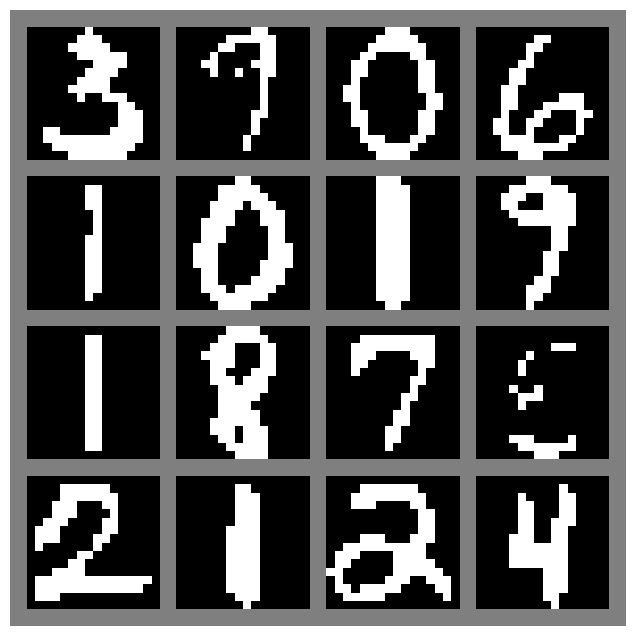

In [8]:
# reload utils and _binarize
# from utils import _binarize
import os

def _binarize(x):
    """
    Binarize the pixel values to -1 and 1.
    """
    return torch.where(x > 0.5, torch.tensor(1.0), torch.tensor(-1.0))


# Load USPS dataset and create dataloaders
transform = transforms.Compose([
    # transforms.Resize(11),
    transforms.ToTensor(),
    transforms.Lambda(_binarize)
])

train_dataset = datasets.USPS(root='USPS/', train=True, download=True, transform=transform)
test_dataset = datasets.USPS(root='USPS/', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, drop_last=False, num_workers=0)

# check the shape of the data
x, _ = next(iter(train_loader))
# print(f"Training data shape: {x.shape}")

# visualize the data
# Visualize some examples from the training set
plt.figure(figsize=(8,8))
grid = torchvision.utils.make_grid(x[:16], nrow=4, normalize=True, value_range=(-1,1), padding=2, pad_value=0.5)
plt.imshow(grid.permute(1,2,0))
plt.axis('off')
plt.show()

In [9]:
model = train_model(img_shape=(1,16,16),
                    batch_size=train_loader.batch_size,
                    lr=1e-3,
                    beta1=0.0,
                    alpha=0.01,
                    method=method,
                    steps=30,
                    step_size=None,
                    epochs=5
                    )

/hpc/dctrl/jy384/miniconda3/envs/myenv/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/dctrl/jy384/miniconda3/envs/myenv/lib/python3.1 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
You are using a CUDA device ('NVIDIA RTX 5000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/hpc/dctrl/jy384/miniconda3/envs/myenv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory 

/hpc/dctrl/jy384/miniconda3/envs/myenv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=12` in the `DataLoader` to improve performance.
/hpc/dctrl/jy384/miniconda3/envs/myenv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=12` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 56/56 [03:30<00:00,  0.27it/s, v_num=2.57e+7]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 56/56 [03:30<00:00,  0.27it/s, v_num=2.57e+7]


In [10]:
model.to(device)
pl.seed_everything(43)
callback = GenerateCallback(batch_size=4, vis_steps=8, num_steps=60)
imgs_per_step = callback.generate_imgs(model)
imgs_per_step = imgs_per_step.cpu()

Seed set to 43


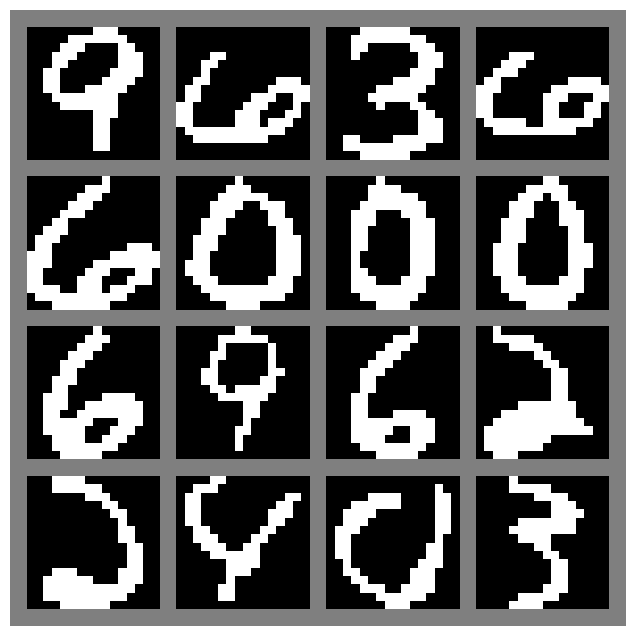

In [11]:
# visualize next(iter(test_loader))
plt.figure(figsize=(8,8))
grid = torchvision.utils.make_grid(next(iter(test_loader))[0][:16], nrow=4, normalize=True, value_range=(-1,1), padding=2, pad_value=0.5)
plt.imshow(grid.permute(1,2,0))
plt.axis('off')
plt.show()


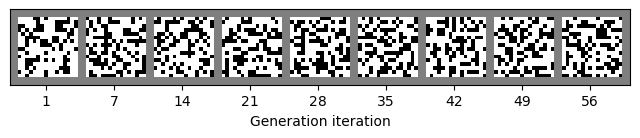

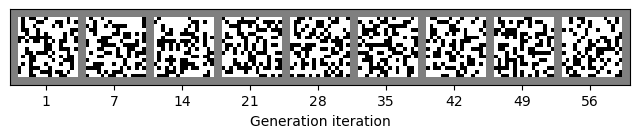

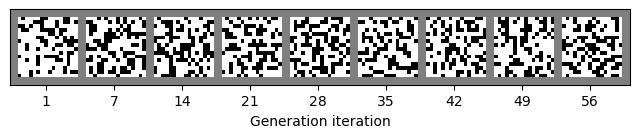

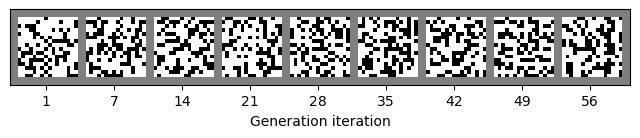

In [12]:
# visualize gibbs sampling
for i in range(imgs_per_step.shape[1]):
    step_size = callback.num_steps // callback.vis_steps
    imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
    imgs_to_plot = torch.cat([imgs_per_step[0:1,i],imgs_to_plot], dim=0)
    grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, value_range=(-1,1), pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(8,8))
    plt.imshow(grid)
    plt.xlabel("Generation iteration")
    plt.xticks([(imgs_to_plot.shape[-1]+2)*(0.5+j) for j in range(len(imgs_to_plot))],
               labels=[1] + list(range(step_size,imgs_per_step.shape[0]+1,step_size)))
    plt.yticks([])
    plt.show()

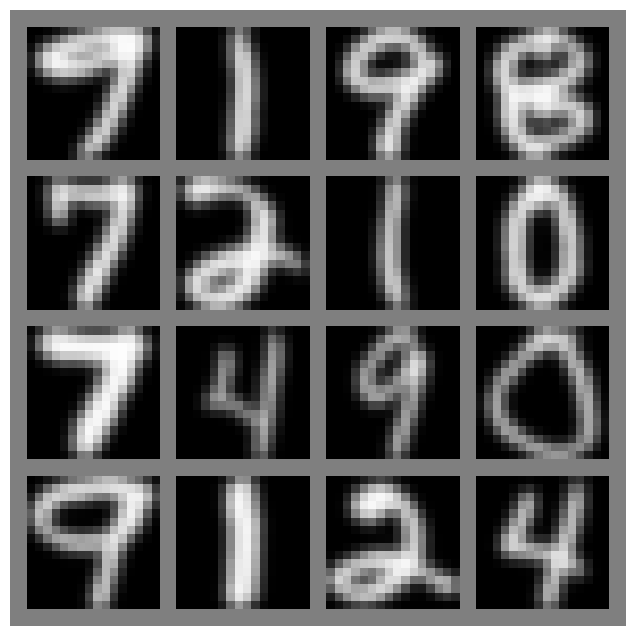

In [13]:
import os


# Load USPS dataset and create dataloaders
transform = transforms.Compose([
    # transforms.Resize(11),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)), # normalize between -1 and 1
    # transforms.Lambda(_binarize) # langevin does not need binarization
])

train_dataset = datasets.USPS(root='USPS/', train=True, download=True, transform=transform)
test_dataset = datasets.USPS(root='USPS/', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, drop_last=False, num_workers=0)

# check the shape of the data
x, _ = next(iter(train_loader))
# print(f"Training data shape: {x.shape}")

# visualize the data
# Visualize some examples from the training set
plt.figure(figsize=(8,8))
grid = torchvision.utils.make_grid(x[:16], nrow=4, normalize=True, value_range=(-1,1), padding=2, pad_value=0.5)
plt.imshow(grid.permute(1,2,0))
plt.axis('off')
plt.show()

In [14]:
model_langevin = train_model(img_shape=(1,16,16),
                    batch_size=train_loader.batch_size,
                    lr=1e-4,
                    beta1=0.0,
                    alpha=0.01,
                    method="langevin",
                    steps=60,
                    step_size=10,
                    epochs=60
                    )

/hpc/dctrl/jy384/miniconda3/envs/myenv/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/dctrl/jy384/miniconda3/envs/myenv/lib/python3.1 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
/hpc/dctrl/jy384/miniconda3/envs/myenv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory saved_models/energy_model_gibbs.ckpt/USPS/lightning_logs/version_25702124/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type     | Params | Mode  | In sizes       | Out sizes
-----------------------------------------------------------------------
0 | cnn  | CNNModel | 60.5 K | train | [1, 1, 16, 16] | [1]      
-------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/hpc/dctrl/jy384/miniconda3/envs/myenv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=12` in the `DataLoader` to improve performance.
/hpc/dctrl/jy384/miniconda3/envs/myenv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=12` in the `DataLoader` to improve performance.


Epoch 59: 100%|██████████| 56/56 [00:03<00:00, 16.69it/s, v_num=2.57e+7]

`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 59: 100%|██████████| 56/56 [00:03<00:00, 16.68it/s, v_num=2.57e+7]


In [15]:
model_langevin.to(device)
pl.seed_everything(43)
callback = GenerateCallback(batch_size=4, vis_steps=8, num_steps=256)
imgs_per_step_langevin = callback.generate_imgs(model_langevin)
imgs_per_step_langevin = imgs_per_step_langevin.cpu()

Seed set to 43


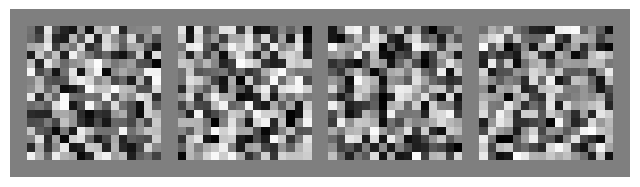

In [16]:
# visualize first step of langevin sampling
plt.figure(figsize=(8,8))
grid = torchvision.utils.make_grid(imgs_per_step_langevin[0][:16], nrow=4, normalize=True, value_range=(-1,1), padding=2, pad_value=0.5)
plt.imshow(grid.permute(1,2,0))
plt.axis('off')
plt.show()


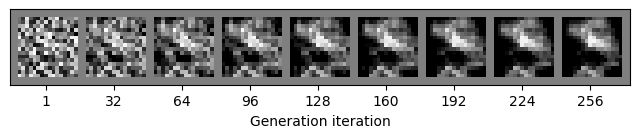

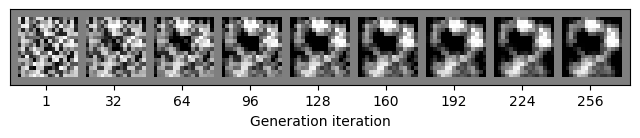

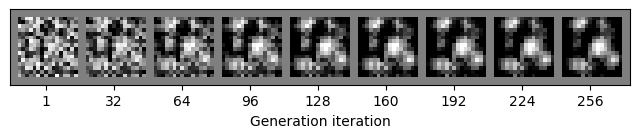

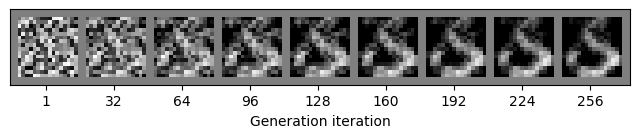

In [22]:
# visualize langevin sampling
for i in range(imgs_per_step_langevin.shape[1]):
    step_size = callback.num_steps // callback.vis_steps
    imgs_to_plot = imgs_per_step_langevin[step_size-1::step_size,i]
    imgs_to_plot = torch.cat([imgs_per_step_langevin[0:1,i],imgs_to_plot], dim=0)
    grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, value_range=(-1,1), pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(8,8))
    plt.imshow(grid)
    plt.xlabel("Generation iteration")
    plt.xticks([(imgs_to_plot.shape[-1]+2)*(0.5+j) for j in range(len(imgs_to_plot))],
               labels=[1] + list(range(step_size,imgs_per_step_langevin.shape[0]+1,step_size)))
    plt.yticks([])
    plt.show()
    